In [1]:
import parser
import pathlib
import numpy as np
import matplotlib.pyplot as plt

def format_frame_no(frame_no):
    return f"{int(frame_no):06d}"

def parse_dim_pair(dim_text):
    if "x" not in dim_text:
        return None
    height_str, width_str = dim_text.split("x", 1)
    if not height_str.isdigit() or not width_str.isdigit():
        return None
    return int(height_str), int(width_str)

def parse_record_dimensions(filename):
    name = pathlib.Path(filename).name
    parts = name.split("_")
    if len(parts) < 5:
        return None
    if not parts[0].isdigit():
        return None
    if "in" not in parts:
        return None
    in_index = parts.index("in")
    if in_index <= 0 or in_index + 1 >= len(parts):
        return None
    crop_part = parts[in_index - 1]
    full_part = parts[in_index + 1]
    if not full_part.endswith(".data"):
        return None
    full_part = full_part[:-5]
    crop_dims = parse_dim_pair(crop_part)
    full_dims = parse_dim_pair(full_part)
    if not crop_dims or not full_dims:
        return None
    return crop_dims, full_dims

def find_scene_color_file(record_dir, frame_no):
    frame_prefix = format_frame_no(frame_no)
    for path in record_dir.glob(f"{frame_prefix}_SceneColor_*x*_in_*x*.data"):
        dims = parse_record_dimensions(path.name)
        if dims:
            crop_dims, full_dims = dims
            return path, crop_dims, full_dims
    return None, None, None

def find_motion_vector_file(record_dir, frame_no):
    frame_prefix = format_frame_no(frame_no)
    for path in record_dir.glob(f"{frame_prefix}_MotionVector_*x*_in_*x*.data"):
        dims = parse_record_dimensions(path.name)
        if dims:
            crop_dims, full_dims = dims
            return path, crop_dims, full_dims
    return None, None, None

def find_scene_depth_file(record_dir, frame_no):
    frame_prefix = format_frame_no(frame_no)
    for path in record_dir.glob(f"{frame_prefix}_SceneDepth_*x*_in_*x*.data"):
        dims = parse_record_dimensions(path.name)
        if dims:
            crop_dims, full_dims = dims
            return path, crop_dims, full_dims
    return None, None, None

def find_translucency_file(record_dir, frame_no):
    frame_prefix = format_frame_no(frame_no)
    for path in record_dir.glob(f"{frame_prefix}_Translucency_*x*_in_*x*.data"):
        dims = parse_record_dimensions(path.name)
        if dims:
            crop_dims, full_dims = dims
            return path, crop_dims, full_dims
    return None, None, None

def scale_for_visualizaion(img01):
    min_value = np.min(img01)
    max_value = np.max(img01)
    z_range = max_value - min_value

    scaled_value = (img01 - min_value) / z_range
    scaled_value = np.clip(scaled_value, 0.0, 1.0)
    return scaled_value

def to_rgb_gray(img):
    if img.ndim == 2:
        return np.repeat(img[..., None], 3, axis=2)
    if img.shape[-1] == 1:
        return np.repeat(img, 3, axis=2)
    return img[..., :3]

SceneColor crop size: 380 480
SceneColor full size: 500 1208


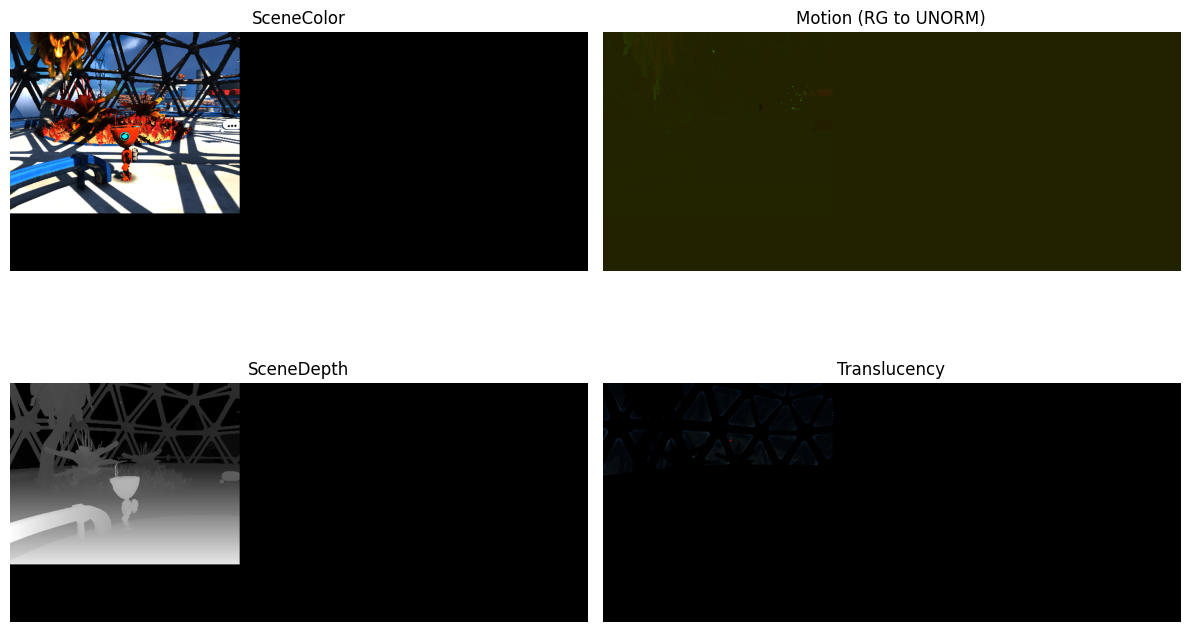

In [2]:
RECORD_FOLDER = "../Saved/NRSRecordSample"
RECORD_DIR = pathlib.Path(RECORD_FOLDER)

FRAME_NO = 852

color_file, color_crop_dims, color_full_dims = find_scene_color_file(RECORD_DIR, FRAME_NO)
if color_file is None:
    raise FileNotFoundError("No SceneColor file found in record directory")

motion_file, motion_crop_dims, motion_full_dims = find_motion_vector_file(RECORD_DIR, FRAME_NO)
scene_depth_file, depth_crop_dims, depth_full_dims = find_scene_depth_file(RECORD_DIR, FRAME_NO)
translucency_file, translucency_crop_dims, translucency_full_dims = find_translucency_file(RECORD_DIR, FRAME_NO)
height, width = color_full_dims
print("SceneColor crop size:", *color_crop_dims)
print("SceneColor full size:", height, width)

color = parser.read_r11g11b10_data(str(color_file), height, width)
motion = parser.read_g16r16_data(str(motion_file), height, width)
scene_depth = parser.read_r32f_data(str(scene_depth_file), height, width)
translucency = parser.read_r16g16b16a16_data(str(translucency_file), height, width)

color_vis = np.clip(color, 0.0, 1.0)

# 一般从纹理中读取的运动向量是[-1, 1]范围内的值，这里将其映射到[0, 1]范围
motion01 = np.clip(motion * 0.5 + 0.5, 0.0, 1.0)
# motion缩放到最小值与最大值的区间，以利于可视化
motion_vis = scale_for_visualizaion(motion01)
motion_rgb = np.zeros((motion_vis.shape[0], motion_vis.shape[1], 3), dtype=np.float32)
motion_rgb[..., 0] = motion_vis[..., 0]
motion_rgb[..., 1] = motion_vis[..., 1]

# 一般从纹理中读取的深度值是Device Z，[0, 1]范围，这里缩放到最小值与最大值的区间，以利于可视化
scene_depth_vis = scale_for_visualizaion(scene_depth)
scene_depth_rgb = to_rgb_gray(scene_depth_vis)

# 透明mask缩放到最小值与最大值的区间，以利于可视化
translucency01 = np.clip(translucency, 0.0, 1.0)
translucency_vis = scale_for_visualizaion(translucency01)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0, 0].imshow(color_vis)
axes[0, 0].set_title("SceneColor")
axes[0, 1].imshow(motion_rgb)
axes[0, 1].set_title("Motion (RG to UNORM)")
axes[1, 0].imshow(scene_depth_rgb)
axes[1, 0].set_title("SceneDepth")
axes[1, 1].imshow(translucency_vis)
axes[1, 1].set_title("Translucency")
for ax in axes.flat:
    ax.axis("off")
plt.tight_layout()
plt.show()